In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,Callback

warnings.filterwarnings('ignore')
sns.set()

2023-07-05 14:39:04.824996: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-05 14:39:04.826276: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 14:39:04.850282: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 14:39:04.850656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 14:39:05.243899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
from glob import glob
from PIL import Image

glob('test_set/test_set/*')

['test_set/test_set/dogs', 'test_set/test_set/cats']

In [3]:
test_dog=pd.DataFrame({'path':glob('test_set/test_set/dogs/*')})
test_cat=pd.DataFrame({'path':glob('test_set/test_set/cats/*')})
train_dog=pd.DataFrame({'path':glob('training_set/training_set/dogs/*')})
train_cat=pd.DataFrame({'path':glob('training_set/training_set/cats/*')})

In [4]:
test_dog['label']='dog'
test_cat['label']='cat'
train_dog['label']='dog'
train_cat['label']='cat'

In [5]:
test=pd.concat([test_dog,test_cat],axis=0)
train=pd.concat([train_dog,train_cat],axis=0)

In [6]:
for i in range(10):
    train=train.sample(frac=1)

<Axes: xlabel='label', ylabel='count'>

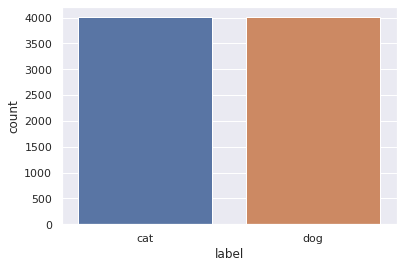

In [7]:
sns.countplot(x=train.label)

<Axes: xlabel='label', ylabel='count'>

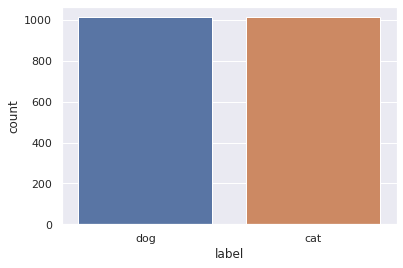

In [8]:
sns.countplot(x=test.label)

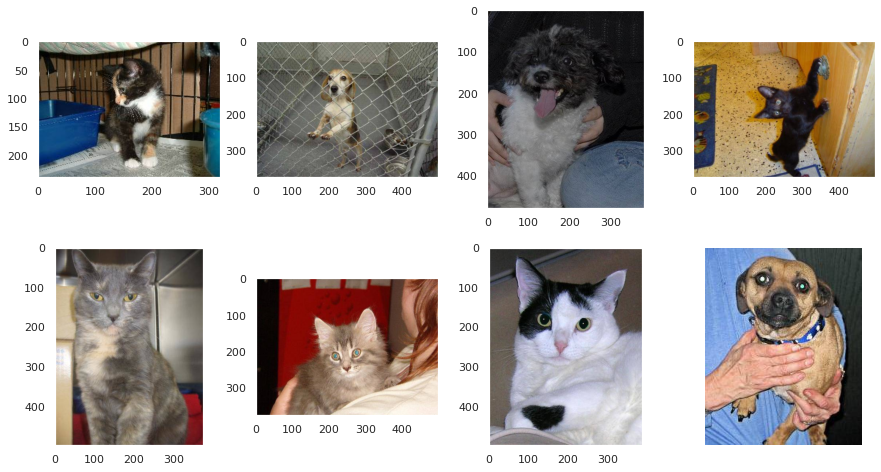

In [9]:
fig,ax=plt.subplots(2,4,figsize=(15,8))
ax=ax.flatten()
for i in range(8):
    ax[i].imshow(Image.open(train['path'].iloc[i]))
    ax[i].grid(False)
    plt.axis('off')

In [10]:
x_train,x_test=train_test_split(train,test_size=0.2,random_state=8)

In [11]:
datagen=ImageDataGenerator(
featurewise_center=True,
rotation_range=20,
zoom_range=0.2,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=True,
vertical_flip=True,
rescale=1/255.,
validation_split=0.2
)

X=datagen.flow_from_dataframe(dataframe=train,x_col='path',y_col='label',batch_size=32,
                                      color_mode='rgb',class_mode='binary',shuffle=True,
                                      subset='training',seed=8,target_size=(256,256)
                                     )

val=datagen.flow_from_dataframe(dataframe=train,x_col='path',y_col='label',batch_size=32,
                                      color_mode='rgb',class_mode='binary',shuffle=True,
                                      subset='validation',seed=8,target_size=(256,256)
                                     )

datagen_test=ImageDataGenerator(
featurewise_center=True,
rotation_range=20,
zoom_range=0.2,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=True,
vertical_flip=True,
rescale=1/255.,
)

Z=datagen_test.flow_from_dataframe(dataframe=test,x_col='path',y_col='label',batch_size=32,
                                  colro_mode='rgb',seed=8,class_mode='binary',shuffle=True,target_size=(256,256))


Found 6404 validated image filenames belonging to 2 classes.
Found 1601 validated image filenames belonging to 2 classes.
Found 2023 validated image filenames belonging to 2 classes.


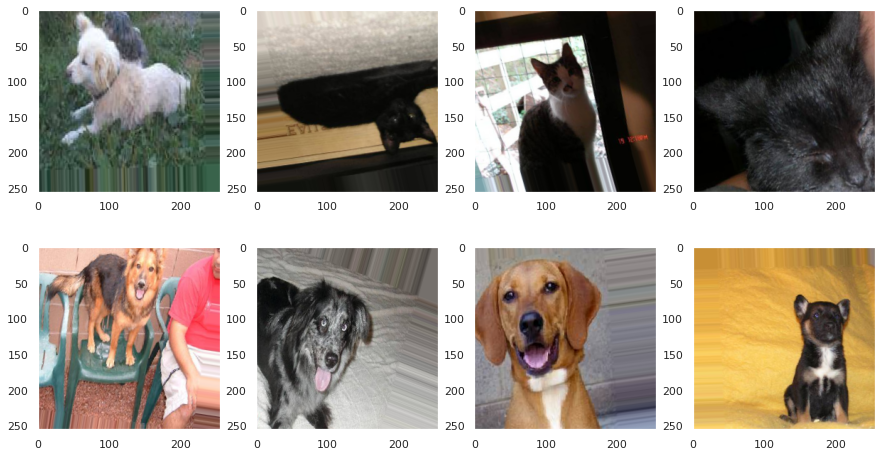

In [12]:
fig,ax=plt.subplots(2,4,figsize=(15,8))
ax=ax.flatten()
for i in range(8):
    ax[i].imshow(X[0][0][i])
    ax[i].grid(False)

In [13]:
batch_size=32
epochs=30

In [14]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization(axis=1))
          
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization(axis=1))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [15]:
from keras.optimizers import RMSprop
optimizer=RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-08,decay=0.0)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics='accuracy')

In [16]:

early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [17]:
history=model.fit(X,epochs=epochs,validation_data=val,
                 callbacks=[early_stopping])

2023-07-05 14:39:08.704970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/30
201/201 [==============================] - ETA: 0s - loss: 13.9591 - accuracy: 0.4981

2023-07-05 14:43:47.107287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


201/201 [==============================] - 296s 1s/step - loss: 13.9591 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.4991
Epoch 2/30
201/201 [==============================] - 287s 1s/step - loss: 0.7684 - accuracy: 0.4963 - val_loss: 1.9236 - val_accuracy: 0.4991
Epoch 3/30
201/201 [==============================] - 286s 1s/step - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 4/30
201/201 [==============================] - 286s 1s/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.4991
Epoch 5/30
201/201 [==============================] - 284s 1s/step - loss: 0.6932 - accuracy: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 6/30
201/201 [==============================] - 284s 1s/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.4991
Epoch 7/30
201/201 [==============================] - 285s 1s/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 8/3

In [18]:
from keras.applications import Xception
from keras.models import Model

xception=Xception(include_top=False,input_shape=(256,256,3))
input_to_model=xception.input
xception.trainable=False

x=Flatten()(xception.output)
x=Dense(256,activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model1=Model(inputs=input_to_model,outputs=output)


model1.compile(optimizer=optimizer,loss='binary_crossentropy',metrics='accuracy')

history1=model1.fit(X,epochs=epochs,validation_data=val,callbacks=[early_stopping],)

2023-07-05 15:50:39.029094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/30
201/201 [==============================] - ETA: 0s - loss: 2.7536 - accuracy: 0.8880

2023-07-05 15:53:17.347233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


201/201 [==============================] - 194s 960ms/step - loss: 2.7536 - accuracy: 0.8880 - val_loss: 0.4656 - val_accuracy: 0.9319
Epoch 2/30
201/201 [==============================] - 192s 956ms/step - loss: 0.4908 - accuracy: 0.9213 - val_loss: 0.2405 - val_accuracy: 0.9488
Epoch 3/30
201/201 [==============================] - 193s 962ms/step - loss: 0.2960 - accuracy: 0.9308 - val_loss: 0.1611 - val_accuracy: 0.9450
Epoch 4/30
201/201 [==============================] - 192s 953ms/step - loss: 0.2612 - accuracy: 0.9352 - val_loss: 0.2942 - val_accuracy: 0.9157
Epoch 5/30
201/201 [==============================] - 192s 954ms/step - loss: 0.2144 - accuracy: 0.9389 - val_loss: 0.1840 - val_accuracy: 0.9425
Epoch 6/30
201/201 [==============================] - 193s 958ms/step - loss: 0.2638 - accuracy: 0.9363 - val_loss: 0.1830 - val_accuracy: 0.9432
Epoch 7/30
201/201 [==============================] - 192s 954ms/step - loss: 0.2287 - accuracy: 0.9418 - val_loss: 0.2070 - val_accura

In [19]:
print(model1.evaluate(Z))

2023-07-05 16:16:17.968415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


64/64 [==============================] - 44s 689ms/step - loss: 0.1695 - accuracy: 0.9397
[0.16954055428504944, 0.9396935105323792]
